<a href="https://colab.research.google.com/github/tfreyd/TensorflowCoursera/blob/main/Machine_Learning_for_Biologists_Workshop_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
In the previous session, we showed you how to build a dataset containing images of colon polyps and corresponding image masks. This session will use an extended version of this dataset to build a machine learning pipeline to automatically segment colon polyps in images collected from real-world colonoscopies.

The dataset we will be using is Kvasir-SEG, which contains 1,000 images with colon polyps collected from colonoscopies held at Bærum Hospital. There is no need to redownload the dataset as it will be done automatically through this notebook. Parts of this notebook was inspired by the tutorial provided by the official keras team at https://keras.io/examples/vision/oxford_pets_image_segmentation.

The machine learning pipeline will mainly consist of the three following steps:

1. Data preparation and loading.
2. Model development and training.
3. Model evaluation and testing.

Each step is equally important in the development of any machine learning-based system. Before we start implementing the pipeline, let's start with preparing the environment with some initial setup.


# Setup
First, we import the external modules and defines some functions that will help us with the implementation.

## Import Modules
Here, we download and import the modules we will be using to implement our machine learning pipeline. The pipeline will be implemented using [Tensorflow](https://www.tensorflow.org), which is a machine learning library developed by Google and is currently the most widely used tool available.



In [1]:
import os
import glob

from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics

## Helper Functions
We define a helper function that will aid us in showing images directly in this notebook. This is purely used for visualization and is not part of developing the machine learning pipeline.

In [2]:
def show_images(images, figsize=(10,10), columns=2):
    plt.figure(figsize=figsize)
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)
        plt.axis('off') 

# Dataset Preparation and Loading
In order to build a machine learning model that can automatically segment polyps in endoscopy images, we need data it can learn from. For the model to learn from data, the data must first be loaded into a format that the model can understand. Furthermore, we also want to organize the data to use one part for training and one part for testing after training has finished. This section covers the data preparation step of developing a machine learning pipeline.


## Download the Dataset
We start by downloading the dataset from the website and extracting the contents. We assign some variables that point to the location of the dataset so that in the future, we only need to change this in one place.

In [3]:
DATASET_URL = "https://datasets.simula.no/kvasir-seg/Kvasir-SEG.zip"
DATASET_ZIP_PATH = os.path.join(os.path.abspath(os.sep), "content", "Kvasir-SEG.zip")
DATASET_DIR_PATH = os.path.join(os.path.abspath(os.sep), "content", "Kvasir-SEG")

if not os.path.exists(DATASET_ZIP_PATH):
    !wget $DATASET_URL
    !unzip $DATASET_ZIP_PATH &> /dev/null

--2021-10-12 11:17:19--  https://datasets.simula.no/kvasir-seg/Kvasir-SEG.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46227172 (44M) [application/zip]
Saving to: ‘Kvasir-SEG.zip’

Kvasir-SEG.zip      100%[===================>]  44.08M  8.08MB/s    in 6.0s    

2021-10-12 11:17:26 (7.29 MB/s) - ‘Kvasir-SEG.zip’ saved [46227172/46227172]



With the dataset downloaded and extracted, let's visualize a couple of image and mask pairs.


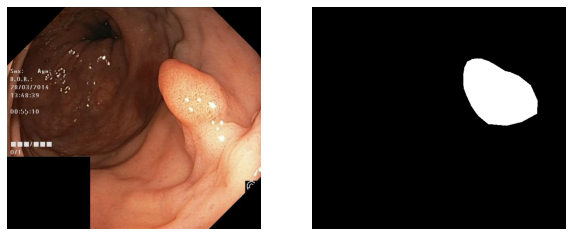

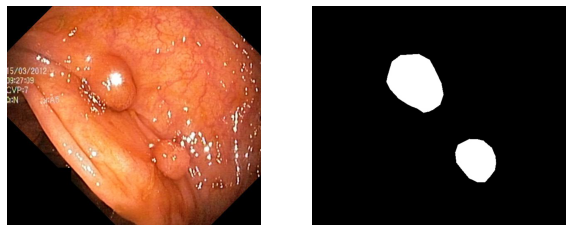

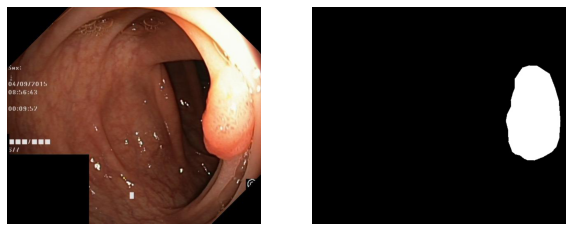

In [4]:
list_of_example_images = [
    "cju32srle1xfq083575i3fl75.jpg",
    "cju33belnbyhm0878yxl42233.jpg",
    "cju5vbo6jldrt0871jf6f1700.jpg"
]

for filename in list_of_example_images:
    example_image = load_img(os.path.join(DATASET_DIR_PATH, "images", filename))
    example_mask = load_img(os.path.join(DATASET_DIR_PATH, "masks", filename))
    show_images([example_image, example_mask])

## Prepare the data
Currently, the images are only stored on disk and not available in our Python program. For the model to process the images, we must first load them into memory. We do this by first getting a list of the location of all image and mask pairs so that we can more easily organize them later.

In [7]:
x_paths = []
y_paths = []

list_of_filenames = os.listdir(os.path.join(DATASET_DIR_PATH, "images"))

for filename in list_of_filenames:
    x_paths.append(os.path.join(DATASET_DIR_PATH, "images", filename))
    y_paths.append(os.path.join(DATASET_DIR_PATH, "masks", filename))

assert len(x_paths) == len(y_paths) 

print("number of image paths: %i" % len(x_paths))
print("number of mask paths: %i" % len(y_paths))

number of image paths: 1000
number of mask paths: 1000


Now that we have all the file paths, we will organize them into three separate partitions; training, validation, and testing. The three partitions will be used as follows.

* **Training Part** The training partition will be used to train the model.
* **Validation Part** The training partition will be used to test the model during training. We use the validation part to verify that the model is learning something from the training dataset.
* **Testing Part** The testing partition will be used to test the model after training. This is the only partition that the model does not see during training.

We will split the data between a development dataset (80%) and a testing dataset (20%) in the following code example. The development dataset is further split into a training dataset (70%) and a validation dataset (30%).

In [8]:
x_development, x_test, y_development, y_test = train_test_split(x_paths, y_paths, test_size=0.20, random_state=0)
x_train, x_valid, y_train, y_valid = train_test_split(x_development, y_development, test_size=0.30, random_state=0)

assert len(x_train) == len(y_train)
assert len(x_train) == len(y_train)
assert len(x_valid) == len(y_valid)
assert len(x_test) == len(y_test)

print("Number of training samples: %i" % len(x_train))
print("Number of validation samples: %i" % len(x_valid))
print("Number of testing samples: %i" % len(x_test))

Number of training samples: 560
Number of validation samples: 240
Number of testing samples: 200


With the image paths organized into their respective datasets, we now create the function responsible for loading the images into memory. Note that the function is complicated as it loads images in batches, which will be described later.

In [9]:
class KvasirSEGDataLoader(keras.utils.Sequence):
    def __init__(self, batch_size, image_size, image_paths, mask_paths):
        self.batch_size = batch_size
        self.image_size = image_size
        self.image_paths = image_paths
        self.target_img_paths = mask_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, index):
        i = index * self.batch_size
        batch_input_img_paths = self.image_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.image_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.image_size)
            x[j] = img
        x = x / 255
        y = np.zeros((self.batch_size,) + self.image_size + (1,), dtype="float32")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.image_size, color_mode="grayscale")
            y[j] = (np.expand_dims(img, 2))
        y = y / 255
        return x, y

# Develop and Train Model
This section builds the machine learning model that will automatically predict a segmentation mask over the provided endoscopy image. A neural network is structured as a series of layers, where inputs are passed through one end, and the output is produced in the other. Each layer has a series of nodes with a weight attached. The input passes through each of these nodes and is multiplied with the weights to produce the output. Below is an image of a simple neural network that takes two inputs and produces one output.

![nn](https://upload.wikimedia.org/wikipedia/commons/3/3d/Neural_network.svg)

Although our segmentation task may sound a bit more difficult, the principles are exactly the same. In our case, the image pixels are the input, and the output is a segmentation mask. However, this can get a bit complicated, so don't worry if you do not understand everything.

## Define Hyperparamters
Before we start implementing the model, we first define a series of hyperparameters used for both the model implementation and training. Hyperparameters are parameters used to configure the training process of the neural network. They control things like how long to train, how many samples should be loaded at once, and how fast we should update the neural network's weights.

In [18]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_function = "binary_crossentropy"
number_of_epochs = 15
batch_size = 16
image_size = (224, 224)

callbacks = [
    keras.callbacks.ModelCheckpoint("model_checkpoint.h5", save_best_only=True)
]

## Implement model
In the function below, we implement a neural network that uses a popular architecture called U-Net, which is probably the most commonly used architecture for image segmentation.



In [19]:
def unet_model(img_size, num_classes=1):
    inputs = keras.Input(shape=img_size + (3,))
    x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x

    for filters in [64, 128, 256]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])
        previous_block_activation = x 

    for filters in [256, 128, 64, 32]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.UpSampling2D(2)(x)

        residual = keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = keras.layers.add([x, residual])  
        previous_block_activation = x 

    outputs = keras.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

## Model Training
Now that we have a function for loading data and building the model, we can put the pieces together and start training. Training is a trial and error process where we pass some data through the model, make a prediction, and tell the model how wrong it is. Using the measurement of how incorrect the prediction was, we can update the neural network's weights so that next time it may perform a bit better. This is done several hundred, thousands, or millions of times until the model reaches some convergence point.

We begin by initializing the data loaders we defined earlier, one for training and one for validation.

In [20]:
training_data_loader = KvasirSEGDataLoader(batch_size, image_size, x_train, y_train)
validation_data_loader = KvasirSEGDataLoader(batch_size, image_size, x_valid, y_valid)

Here we initialize the model using the above model function, where we also define the size of the image that we plan to insert. Machine learning models require uniform input sizes, and we do not want them to be too big as it will drastically slow down training time.

In [21]:
model = unet_model(image_size, num_classes=1)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 112, 112, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 112, 112, 32) 128         conv2d_9[0][0]                   
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 112, 112, 32) 0           batch_normalization_15[0][0]     
____________________________________________________________________________________________

Now we are finally at the step of training the model. The code snippet below trains the model using the hyperparameters defined earlier.

In [22]:
model.compile(optimizer=optimizer, loss=loss_function)
model.fit(training_data_loader, epochs=number_of_epochs, validation_data=validation_data_loader, callbacks=callbacks)
model.save("model_final.h5")

Epoch 1/15
35/35 [==============================] - 19s 473ms/step - loss: 8.7694 - val_loss: 2.5486


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
35/35 [==============================] - 16s 450ms/step - loss: 0.5278 - val_loss: 0.4243
Epoch 3/15
35/35 [==============================] - 16s 450ms/step - loss: 0.3859 - val_loss: 0.4111
Epoch 4/15
35/35 [==============================] - 16s 452ms/step - loss: 0.3706 - val_loss: 0.3914
Epoch 5/15
35/35 [==============================] - 16s 452ms/step - loss: 0.3635 - val_loss: 0.3690
Epoch 6/15
35/35 [==============================] - 16s 453ms/step - loss: 0.3552 - val_loss: 0.3718
Epoch 7/15
35/35 [==============================] - 16s 451ms/step - loss: 0.3413 - val_loss: 0.3631
Epoch 8/15
35/35 [==============================] - 16s 452ms/step - loss: 0.3292 - val_loss: 0.3619
Epoch 9/15
35/35 [==============================] - 16s 450ms/step - loss: 0.3259 - val_loss: 0.3494
Epoch 10/15
35/35 [==============================] - 16s 451ms/step - loss: 0.3210 - val_loss: 0.4199
Epoch 11/15
35/35 [==============================] - 16s 454ms/step - loss: 0.3157 - val_l

The training process can be really slow. So to speed up the process, we can load the weights of a previously trained model so that we do not have to perform the training process every time we want to run the model.

In [16]:
!wget -O model.h5 https://www.dropbox.com/s/yh1545rn9sg3rtd/model.h5?dl=1
model = keras.models.load_model(os.path.join(os.path.abspath(os.sep), "content", "model.h5"))
model.summary()

--2021-10-12 11:48:50--  https://www.dropbox.com/s/yh1545rn9sg3rtd/model.h5?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/yh1545rn9sg3rtd/model.h5 [following]
--2021-10-12 11:48:50--  https://www.dropbox.com/s/dl/yh1545rn9sg3rtd/model.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc905b94f9cf3fda1694af252fd0.dl.dropboxusercontent.com/cd/0/get/BX4KE3vl0hNpquiHrrdhZoR99Umpcp01SizWZcbYdXETD4V2GuUuH79xKlWRPnnG6o7EjMcd5QOMIncTIhlkAEWGUA1Zcoa5uXWFoW53-oufklvOjko4AdRjcP-kb5USiaZ1OCLS6lIOX9HcVsAf7puc/file?dl=1# [following]
--2021-10-12 11:48:50--  https://uc905b94f9cf3fda1694af252fd0.dl.dropboxusercontent.com/cd/0/get/BX4KE3vl0hNpquiHrrdhZoR99Umpcp01SizWZcbYdXETD4V2GuUuH79xKlWRPnnG6o7EjMcd5QOMIncTIhlkAEWGUA1Zcoa5uXWF

# Model Evaluation and Testing
Now that the model is finished training, it's time to verify that it works as expected. We do this by evaluating the model on the previously defined testing dataset. But first, let's look at some of the predictions our model is making.

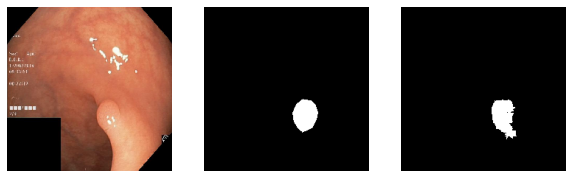

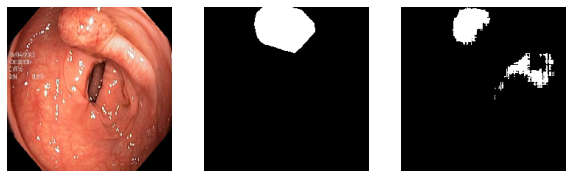

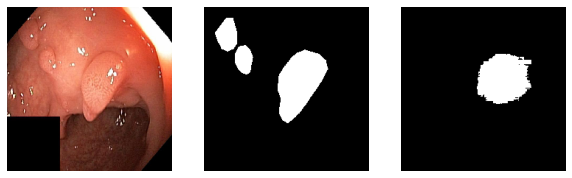

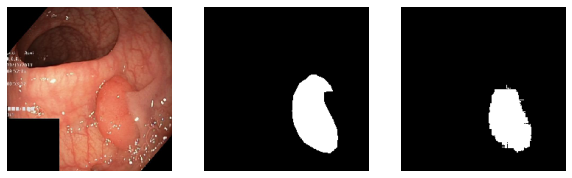

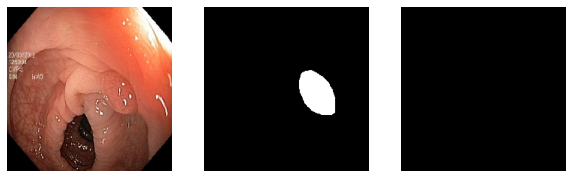

In [17]:

test_data_loader = KvasirSEGDataLoader(1, image_size, x_test, y_test)

for index in range(5, 10):

    test_image, test_mask = test_data_loader[index]

    pred_mask = model.predict(test_image)
    test_image = test_image * 255

    test_image = Image.fromarray(test_image.squeeze().astype("uint8"))
    test_mask = Image.fromarray(test_mask.squeeze() > .5)
    pred_mask = Image.fromarray(pred_mask.squeeze() > .5)

    show_images([test_image, test_mask, pred_mask], columns=3)

These predictions look ok but let's get a general sense of how our model performs across the entire testing dataset. To do this, we define a variety of different metrics that should give us an idea of how the model performs.

The metrics we will use are as follows:

![pixel_privacy](https://stevenhicks.xyz/static/pixel_accuracy.png)

The pixel accuracy is calculated by treating each pixel in the image as a binary classification mask and computing the accuracy from the results. In the equation above, TP is the true positives, TN is the true negatives, FP is the false positives, and FN is the false negatives for the pixel classification. The pixel accuracy ranges from 0 to 1, where 1 represents a perfect segmentation.

![precision](https://stevenhicks.xyz/static/precision.png)

The precision denotes the proportion of pixels that are correctly segmented positive (white) pixels against all positive pixels. The precision ranges from 0 to 1, where 1 means that the whole region containing the polyp was correctly segmented, and 0 denotes the opposite.

![recall](https://stevenhicks.xyz/static/recall.png)

The recall is similar to the precision but is calculated based on the ratio of pixels that are correctly segmented positive (white) pixels against all correctly segmented pixels. The recall is bounded between 0 and 1, where 1 represents perfectly segmenting the polyp, and 0 would be missing the polyp completely. 

![dice](https://stevenhicks.xyz/static/dice.png)

The Sørensen–Dice coefficient, also called just the Dice coefficient or F1 Score, is a similarity metric used to gauge the similarity between two samples A and B. The metric ranges from 0 to 1, where 0 means the two samples are completely different, and 1 means that they are the same.

![iou](https://stevenhicks.xyz/static/iou.png)

The Intersection over Union (IoU), also called the Jaccard index, is similar to the Dice score and measures the similarity between two samples. Like Dice, the IoU score ranges from 0 to 1.

In [23]:
def process_mask(mask):
    mask = mask > 0.5
    mask = mask.astype(np.uint8)
    mask = mask.reshape(-1)
    return mask

CSV_VAL_ORDER = ["Accuracy", "Jaccard", "Dice", "Recall", "Precision"]    
all_metrics = []

for test_image, test_mask in test_data_loader:
    
    pred_mask = model.predict(test_image)

    y_pred = process_mask(pred_mask)
    y_true = process_mask(test_mask)
    
    score_accuracy = metrics.accuracy_score(y_true, y_pred)
    score_jaccard = metrics.jaccard_score(y_true, y_pred, average="binary")
    score_dice = metrics.f1_score(y_true, y_pred, average="binary")
    score_recall = metrics.recall_score(y_true, y_pred, average="binary")
    score_precision = metrics.precision_score(y_true, y_pred, average="binary", zero_division=0)

    all_metrics.append([score_accuracy, score_jaccard, score_dice, score_recall, score_precision])

mean_score = np.mean(all_metrics, axis=0)
print("\n".join(["%s: %0.4f" % (header, score) for header, score in zip(CSV_VAL_ORDER, mean_score)]))

Accuracy: 0.1504
Jaccard: 0.1504
Dice: 0.2425
Recall: 1.0000
Precision: 0.1504
